# Data Prep for Hurricane Time Series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
%matplotlib inline
import pandas as pd
import os
import scipy.spatial as space
from sklearn import manifold
from sklearn import decomposition
from matplotlib import colors as mcolors
os.chdir('path')
plt.rcParams["font.family"] = "arial"

import datetime
from tqdm import tqdm

pd.set_option('display.max_columns', None)

The below imports and organizes count data

In [2]:
#Create broader groups for the ifcb categories, PA/SS

unused_cnn = ['Acantharian','Anabaena','Apedinella', 'RoundCell',
          'Closterium','Dictyocha','Dinobryon','Ebria','Freshwater_green','Phaeocystis','Pterosperma1',
           'Cyanobacteria', 'cyano_chain_sm','filament','Sarcodines',
             'Freshwater_green','freshwater_1']

dia_cnn = ['Chaetoceros','Chaetoceros_danicus','Chaetoceros_peruvianus','Chaetoceros_simplex','Chaetoceros_single',
         'Chaetoceros_socialis','pennate','Asterionellopsis','Asterionellopsis_single','DactFragCeratul','Thalassionema',
        'Dactyliosolen_blavyanus','Ditylum','Eucampia','Eucampiacornuta','Hemiaulus_curved','Hemiaulus_straight','Odontella',
        'Skeletonema','Thalassiosira','centric10','Centric','Guinardia', 'Leptocylindrus','Rhizosolenia','Cylindrotheca',
        'Pleurosigma','Pseudonitzschia','Bacillaria','Corethron','Cymatosira','Entomoneis','Ephemera',
         'Licmophora','Paralia','auxospore']

dinos_cnn = ['Alexandrium','Brachidinium','Akashiwo','Ceratoperidinium','Dinoflagellate_1','Dinophysis',
         'Dinophysis_caudata','Gyrodinium','Karenia_brevis',
        'Karenia_spp','Katodinium','Margalefidinium','Oxyrrhis','Oxytoxum','P_cordatum','P_hartmannii',
         'P_texanum','P_triestinum',
        'Polykrikos','Prorocentrum','Protoperidinium','Pyrophacus','Scrippsiella','Torodinium','Tripos',
        'Tripos_horridum_muelleri','dino10','dino30','dino50','Phalacroma','Warnowia']

cili_cnn = ['ciliate_small','Strombidinopsis','Strom_pulchrum','Strom_Strob_Mix','Tin_aggl','Tin_hyal',
        'Mesodinium_rubrum','Tontonia','Laboea','Hypotrich']

flags_cnn = ['Euglenoid','Heterosigma','Ochromonas','Oltmannsiella','Teleaulax','cf_Eutreptiella','flagellate','Chattonella',
         'Pyramimonas','Vicicitus_globosus','cf_Chrysochromulina_parkae','Chrysochromulina_lanceolata']


In [3]:
### Load and process stream discharge data
usgs = os.listdir('path')

for i  in tqdm(range(0,len(usgs))):
    df = pd.read_csv('path'+usgs[i], header = 0,
                parse_dates = [['date','time']])

    df = df.set_index(['date_time'],drop=True)
    df.rename(columns = {'discharge':usgs[i]}, inplace = True)
    
    df = df.drop(['agency','station','tz','status'],axis=1)
    
    if i == 0: 
        out = pd.DataFrame(df)
    
    else:
        out = out.join(df,how = 'outer')
        
out = out.resample('1D').mean()
out['total'] = out.sum(axis=1)*0.0283

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:10<00:00, 44.30s/it]


In [2]:
#########Load physical data, from NERRS
phys = pd.read_csv("path", header = 0, index_col = 2)

phys.index = pd.DatetimeIndex(phys.index)

phys = phys.reset_index(drop = False)

for i in phys.columns[4:]:
    if 'F_' in i:
        phys[i[2:]].loc[phys.loc[~phys[i].isin(['<0> ','<4> ','<5> ','<3> '])].index] = np.nan
        
phys.index = phys['DateTimeStamp']

phys.to_csv('path')

phys_data = phys[['ATemp','WSpd','Wdir','TotPAR','TotPrcp','Temp','Sal','DO_mgl','Depth','pH','Turb','ChlFluor']]

phys_data = phys_data.astype(float).resample('1D').mean()

phys_data['TotPrcp'] = phys['TotPrcp'].astype(float).resample('1D').sum()

phys_data.index = phys_data.index.tz_localize(None)

C:\Users\Jim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3,4,10,12,17,19,21,23,24,25,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Jim\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
#Read in TABS current data
tabs = pd.read_csv('path',header = 0, index_col = 0)
tabs.index = pd.to_datetime(tabs.index)
tabs['u'] = tabs['u'].mask(tabs['u'] > 800, np.nan)
tabs['u'] = tabs['u'].mask(tabs['u'] < -800, np.nan)
tabs.index = tabs.index.tz_localize(tz = 'UTC').tz_convert(tz = 'US/Central')
tabs['along'] = (tabs.u*np.cos(45))+(tabs.v*np.sin(45))
tabs['across'] = (-tabs.u*np.sin(45))+(tabs.v*np.cos(45))
tabs = tabs.resample('1D').mean()
tabs.index = tabs.index.tz_localize(None)
tabs = tabs.loc[np.logical_not(tabs.index.year.isin([2007,2018,2019,2020,2021]))]

tabs.to_csv('path')

In [7]:
# Load surge data, combine into single csv

td = pd.DataFrame(columns = ['av'])

f = os.listdir('path')

for i in f[1:]:

    surge = pd.read_csv('path'+i, header = 0)

    surge = surge.rename(columns = {'#YY':'Year','MM':'Month','DD':'Day','hh':'Hour','mm.1':'minute'})

    surge['date'] = pd.to_datetime(surge[['Year','Month','Day','Hour','minute']])

    surge.index = surge['date']

    tides = surge[surge.columns[5:15]]
    
    tides.index = tides.index.tz_localize(tz = 'UTC').tz_convert(tz = 'US/Central')

    tides[tides == 99] = np.nan
    
    #TG1 - TG10 represent 6 minute intervals in every hour, and are offset by 10 to prevent negatives, so must subtract 10
    tides = tides - 10

    tides['av'] = tides.mean(axis=1)
    
    tides = tides*0.3048
    
    #tides = tides.replace(np.nan,-999)
    
    tides = tides.resample('1D').mean()
    
    tides.index = tides.index.tz_localize(None)
    
    td = td.append(pd.DataFrame(tides['av']))

#Save CSV
    
td[0:-2].to_csv('path')

#td2 = td[np.logical_not(td.index.month.isin([6,7,8,9,10]))]

#td2.to_csv('C:\\Users\\Jim\\Desktop\\hurricane_time_series\\tides_small.csv')

C:\Users\Jim\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jim\Anaconda3\lib\site-packages\pandas\core\frame.py:3215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
C:\Users\Jim\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [8]:
dates = pd.read_csv('path', header = 0)

dates=dates.dropna(axis=0)

dates = dates[0:13]
dates

,event,start,end,loc
0,alex,6/23/2010,8/4/2010,pa
1,hermine,9/1/2010,10/13/2010,pa
2,don,7/23/2011,9/3/2011,pa
3,ingrid,9/9/2013,10/21/2013,pa
4,dolly14,8/24/2014,10/5/2014,pa
5,bill,6/9/2015,7/20/2015,pa
6,patricia,10/16/2015,11/27/2015,pa
7,newton,9/1/2016,10/13/2016,pa
8,cindy,6/15/2017,7/27/2017,pa
9,dolly08,7/16/2008,8/27/2008,pa


In [40]:
#porta_raw = pd.read_csv('porta\\porta_carbon_concat.csv',header = 0,index_col = 0)
porta_raw = pd.read_csv('path',header = 0 , index_col = 0)
mls = pd.read_csv('path',header = 0,index_col = 0)

porta_raw.index = pd.to_datetime(porta_raw.index)
mls.index = pd.to_datetime(mls.index)
porta_raw['ml_analyzed'] = np.nan

new = pd.merge(porta_raw, mls, right_index = True, left_index = True)
new = new.drop(['ml_analyzed_x'],axis=1)

test = new[new.columns[0:-1]]

test = test.div(new['ml_analyzed_y'],axis=0)

test = test.astype(float)

test = test.replace([np.inf, -np.inf], np.nan)


test = test.drop(['other','unclassified','detritus','Beads','bubble','blurry','zooplankton',
                  'Oyster_larvae'], axis=1)

In [39]:
test = [dia_cnn, dinos_cnn, cili_cnn, flags_cnn]

hhh = porta.resample('1D').mean()

preh = pd.DataFrame(hhh.loc['2017-08-20':'2017-08-25'].mean()).T

xx = pd.DataFrame(index = [0], columns = simplecol)

for i in range(0,4):
    xx[xx.columns[i]] = preh[test[i]].sum(axis=1)
    
xx['Other'] = preh[unused_cnn].sum(axis=1)

xx/xx.sum(axis=1)[0]

,Diatoms,Dinoflagellates,Ciliates,Flagellates,Other
0,0.224075,0.428196,0.154106,0.040855,0.152768


In [41]:
#Load data
porta = test

#Make indices datetime format
porta.index = porta.index.tz_localize(tz = 'UTC').tz_convert(tz = 'US/Central')

porta = porta.resample('1D').mean()

porta.to_csv('path')

porta.index = porta.index.tz_localize(None)

cats = porta.columns

#Duplicate for tracking storm influence and return
porta2 = porta

#Create empty dataframe to be filled
storm_coms = pd.DataFrame(columns = porta.columns)

#Add columns for storm
storm_coms['storm'] = np.nan
storm_coms['station'] = np.nan
storm_coms['date'] = np.nan
storm_coms['event'] = np.nan

phys_data2 = phys_data
out2 = out
tabs2 = tabs

#Loop to extract storm data
for i in range(0,len(dates)):
        
    #r = pd.DatetimeIndex(pd.date_range(start = dates['start'][i], end = dates['end'][i])).tz_localize(tz = 'US/Central')
    
    r = pd.DatetimeIndex(pd.date_range(start = dates['start'][i], 
                    end = pd.to_datetime(dates['end'][i])))
    
    x = porta.loc[r]
    x['storm'] = np.nan
    x['station'] = np.nan
    x['storm'].loc[r] = dates['event'][i]
    x['station'].loc[r] = dates['loc'][i]
    x['date'] = r
    x['event'] = np.nan
    
    cc = 1
    x = x.reset_index(drop = True)
    for t in range(0,len(x)):
        x.event[t] = dates['event'][i]+str(cc)
        cc = cc+1
        
    x.index = x.storm
    storm_coms = storm_coms.append(x)
    
    #Remove hurricane dates from environmental parameters
    #porta = porta.drop(r, errors = 'ignore')
    #phys_data2 = phys_data2.drop(r, errors = 'ignore')
    #out2  = out2.drop(r,errors = 'ignore')
    #tab2 = tabs2.drop(r, errors = 'ignore')
    
#storm_coms.to_csv('C:\\Users\\Jim\\Desktop\\lookhere.csv')
len(storm_coms)

C:\Users\Jim\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Jim\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


558

In [33]:
storm_coms.index = storm_coms['date']
storm_coms.index = pd.DatetimeIndex(storm_coms.index)
storm_coms

,Acantharian,Akashiwo,Alexandrium,Anabaena,Apedinella,Asterionellopsis,Asterionellopsis_single,Bacillaria,Brachidinium,Centric,Ceratoperidinium,Chaetoceros,Chaetoceros_danicus,Chaetoceros_peruvianus,Chaetoceros_simplex,Chaetoceros_single,Chaetoceros_socialis,Chattonella,Chrysochromulina_lanceolata,Closterium,Corethron,Cyanobacteria,Cylindrotheca,Cymatosira,DactFragCeratul,Dactyliosolen_blavyanus,Dictyocha,Dinobryon,Dinoflagellate_1,Dinophysis,Dinophysis_caudata,Ditylum,Ebria,Entomoneis,Ephemera,Eucampia,Eucampiacornuta,Euglenoid,Freshwater_green,Guinardia,Gyrodinium,Hemiaulus_curved,Hemiaulus_straight,Heterosigma,Hypotrich,Karenia_brevis,Karenia_spp,Katodinium,Laboea,Leptocylindrus,Licmophora,Margalefidinium,Mesodinium_rubrum,Ochromonas,Odontella,Oltmannsiella,Oxyrrhis,Oxytoxum,P_cordatum,P_hartmannii,P_texanum,P_triestinum,Paralia,Phaeocystis,Phalacroma,Pleurosigma,Polykrikos,Prorocentrum,Protoperidinium,Pseudonitzschia,Pterosperma1,Pyramimonas,Pyrophacus,Rhizosolenia,RoundCell,Sarcodines,Scrippsiella,Skeletonema,Strom_Strob_Mix,Strom_pulchrum,Strombidinopsis,Teleaulax,Thalassionema,Thalassiosira,Tin_aggl,Tin_hyal,Tontonia,Torodinium,Tripos,Tripos_horridum_muelleri,Vicicitus_globosus,Warnowia,auxospore,centric10,cf_Chrysochromulina_parkae,cf_Eutreptiella,ciliate_small,cyano_chain_sm,dino10,dino30,dino50,filament,flagellate,freshwater_1,pennate,storm,station,date,event
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-06-23,76.543086,40.847973,0.000000,6.643793,13.783538,449.954632,15.051651,0.000000,2.668282,1007.575899,8.093901,2393.257180,26.357945,168.048793,220.305091,127.314121,9.126110,42.497220,16.057016,0.000000,338.784553,5.891027,270.012035,141.105702,2358.772358,312.818899,20.873573,2.215556,0.000000,0.000000,19.791943,361.044304,0.0,36.754572,329.682603,56.606144,134.530388,13.045169,0.000000,1505.940702,3.652782,279.909309,6981.979897,906.063517,112.588980,29.865527,38.172728,2.035656,64.451394,158.725842,12.150079,24.636037,244.283166,8.316002,94.800007,0.000000,0.00000,7.102191,126.938770,88.631709,358.342647,66.690583,0.000000,16.569087,0.000000,78.680191,126.614585,25.908048,10.066056,34.028985,2.480508,1.817120,203.793887,1780.650996,1429.734510,16.222367,236.524285,276.448110,1831.512777,142.086966,233.479566,16.272018,314.489256,178.837073,165.184414,219.367888,2284.760706,44.766346,303.206122,0.000000,263.317364,19.454466,0.531389,41.491368,16.725216,17.167353,44.275857,0.000000,160.145304,268.829650,239.135096,13.456616,212.065554,0.0,755.833992,alex,pa,2010-06-23,alex1
2010-06-24,56.156602,131.135319,0.000000,2.049174,6.682440,172.105259,6.820267,0.000000,0.000000,366.310097,26.863634,634.386978,10.757134,103.448673,160.317772,47.943910,2.353738,44.310509,17.863210,0.000000,201.798043,3.758781,138.892868,145.375173,1880.612977,100.379991,2.411856,0.000000,0.000000,0.000000,0.000000,56.686333,0.0,37.899847,204.573413,11.757772,126.101459,4.689749,0.000000,593.292447,11.002544,118.049117,2368.175080,520.816953,34.285564,9.385996,37.724806,7.666294,25.317694,204.548715,10.044015,26.251384,132.635663,7.650637,58.081662,0.000000,0.00000,2.384321,104.997979,0.000000,244.689003,34.937662,13.968803,9.664751,0.000000,146.423093,0.000000,34.106034,29.482476,31.317095,2.462709,0.000000,0.000000,708.474204,726.559135,10.261618,201.981051,21.403979,869.825608,39.661546,50.511075,12.960754,153.109916,55.514793,91.628934,213.456431,1498.348148,194.075492,267.831078,85.398545,171.940588,2.102648,0.958299,17.097993,12.782172,9.570608,21.262421,0.054747,113.793947,268.044784,219.128591,10.481994,174.970487,0.0,586.472631,alex,pa,2010-06-24,alex2
2010-06-25,63.534213,134.269874,0.000000,2.636205,5.913687,200.605298,14.021097,0.000000,0.000000,572.969193,7.345335,534.513008,8.368703,63.065045,134.988210,37.832655,0.282818,0.000000,19.852583,0.000000,147.966844,15.967697,171.402474,247.467382,3146.893277,99.713885,3.739838,3.794587,0.000000,0.000000,0.0000

In [14]:
l1

,Acantharian,Akashiwo,Alexandrium,Anabaena,Apedinella,Asterionellopsis,Asterionellopsis_single,Bacillaria,Brachidinium,Centric,Ceratoperidinium,Chaetoceros,Chaetoceros_danicus,Chaetoceros_peruvianus,Chaetoceros_simplex,Chaetoceros_single,Chaetoceros_socialis,Chattonella,Chrysochromulina_lanceolata,Closterium,Corethron,Cyanobacteria,Cylindrotheca,Cymatosira,DactFragCeratul,Dactyliosolen_blavyanus,Dictyocha,Dinobryon,Dinoflagellate_1,Dinophysis,Dinophysis_caudata,Ditylum,Ebria,Entomoneis,Ephemera,Eucampia,Eucampiacornuta,Euglenoid,Freshwater_green,Guinardia,Gyrodinium,Hemiaulus_curved,Hemiaulus_straight,Heterosigma,Hypotrich,Karenia_brevis,Karenia_spp,Katodinium,Laboea,Leptocylindrus,Licmophora,Margalefidinium,Mesodinium_rubrum,Ochromonas,Odontella,Oltmannsiella,Oxyrrhis,Oxytoxum,P_cordatum,P_hartmannii,P_texanum,P_triestinum,Paralia,Phaeocystis,Phalacroma,Pleurosigma,Polykrikos,Prorocentrum,Protoperidinium,Pseudonitzschia,Pterosperma1,Pyramimonas,Pyrophacus,Rhizosolenia,RoundCell,Sarcodines,Scrippsiella,Skeletonema,Strom_Strob_Mix,Strom_pulchrum,Strombidinopsis,Teleaulax,Thalassionema,Thalassiosira,Tin_aggl,Tin_hyal,Tontonia,Torodinium,Tripos,Tripos_horridum_muelleri,Vicicitus_globosus,Warnowia,auxospore,centric10,cf_Chrysochromulina_parkae,cf_Eutreptiella,ciliate_small,cyano_chain_sm,dino10,dino30,dino50,filament,flagellate,freshwater_1,pennate,diatom_perc,dino_perc,ciliates_perc,diatom_tot,dino_tot,ciliates_tot
Station,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GI,0,0,0,0,0.000000,0.000000,0.00000,0,0,196.105976,0.000000,58.502512,0,0.000000,0,21.420178,0.000000,0.000000,0,0,0,12.207502,41.505611,0.000000,42.045025,0.000000,0,0,69.684976,0,0,0.000000,0,0,40.654034,0.000000,0,0.000000,0,22.478807,88.112084,0.000000,0,0.000000,238.588976,50.583707,100.510163,16.834264,0.000000,0.000000,0.000000,0.000000,53.022390,0.000000,0,0.000000,0,0.000000,56.549482,696.998041,0.000000,0.000000,93.56349,0.000000,0,0.000000,0,0.000000,12.132576,7.091638,0.000000,0,0,7.604884,685.417027,0,82.418768,0.000000,1599.171805,0,0,26.188363,16.469488,48.472693,0.000000,0.000000,2037.951606,456.379867,0,0,0,0.000000,14.950974,19.277647,0,9.367768,0.000000,3.494174,149.889057,389.199269,529.059638,0.00000,50.317182,0.000000,23.028104,0.080966,0.334482,0.486998,653.171058,2698.351891,3928.734777
S01,0,0,0,0,0.000000,0.000000,0.00000,0,0,16.140719,0.000000,0.000000,0,0.000000,0,15.760422,0.000000,0.000000,0,0,0,0.000000,4.643652,0.000000,0.000000,0.000000,0,0,37.152883,0,0,0.000000,0,0,0.000000,0.000000,0,22.591023,0,0.000000,27.818154,0.000000,0,0.000000,0.000000,0.000000,29.280863,5.919219,0.000000,0.000000,0.000000,0.000000,1184.211081,0.000000,0,0.000000,0,5.215918,17.830761,0.000000,0.000000,6.290535,0.00000,0.000000,0,0.000000,0,54.780697,0.000000,6.993326,0.000000,0,0,10.737644,519.279199,0,81.494936,0.000000,1303.010882,0,0,27.012389,4.257273,0.000000,0.000000,0.000000,2596.204122,727.134053,0,0,0,0.000000,20.457377,39.097767,0,141.520960,0.000000,0.000000,350.972602,672.398292,32.323782,0.00000,61.159302,0.000000,36.330323,0.019163,0.254233,0.630853,154.418505,2048.612693,5083.426086
S06,0,0,0,0,6.343526,0.000000,0.00000,0,0,108.324277,221.837719,109.674589,0,14.010493,0,26.299397,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,178.014782,46.908718,0,0,77.008386,0,0,0.000000,0,0,0.000000,0.000000,0,34.581237,0,38.619846,135.929610,0.000000,0,56.821887,355.390985,0.000000,161.456353,0.000000,3485.892082,0.000000,0.000000,156.248304,1108.984653,0.000000,0,0.000000,0,0.000000,15.901672,0.000000,0.000000,17.261247,0.00000,0.000000,0,0.000000,0,149.525891,419.617494,0.000000,0.000000,0,0,87.030023,1357.070390,0,185.552676,202.151834,50068.372827,0,0,353.663105,0.000000,39.420604,95.973935,0.000000,2281.281929,1428.658163,0,0,0,0.000000,16.328358,37.916762,0,186.171376,0.000000,0.000000,1616.227251,715.324068,511.202007,0.00000,160.425198,0.000000,4.315395,0.013716,0.087696,0.86606

In [12]:
#Load harvey data
l1 = pd.read_csv('path to carbon l1',
                 header = 0,index_col = 0)

l1 = l1[porta.columns]

l1 = l1.groupby(l1.index).mean()

l1['diatom_perc'] = l1[dia_cnn].sum(axis=1)/l1[porta.columns].sum(axis=1)
l1['dino_perc'] = l1[dinos_cnn].sum(axis=1)/l1[porta.columns].sum(axis=1)
l1['ciliates_perc'] = l1[cili_cnn].sum(axis=1)/l1[porta.columns].sum(axis=1)

l1['diatom_tot'] = l1[dia_cnn].sum(axis=1)
l1['dino_tot'] = l1[dinos_cnn].sum(axis=1)
l1['ciliates_tot'] = l1[cili_cnn].sum(axis=1)

l3 = pd.read_csv('path to carbon l3',
                 header = 0,index_col = 0)

l3 = l3[porta.columns]

l3 = l3.groupby(l3.index).mean()

l3['diatom_perc'] = l3[dia_cnn].sum(axis=1)/l3[porta.columns].sum(axis=1)
l3['dino_perc'] = l3[dinos_cnn].sum(axis=1)/l3[porta.columns].sum(axis=1)
l3['ciliates_perc'] = l3[cili_cnn].sum(axis=1)/l3[porta.columns].sum(axis=1)

l3['diatom_tot'] = l3[dia_cnn].sum(axis=1)
l3['dino_tot'] = l3[dinos_cnn].sum(axis=1)
l3['ciliates_tot'] = l3[cili_cnn].sum(axis=1)

cruise = l1.append(l3)

cruise[porta.columns] = np.log10(cruise[porta.columns]+1)

cruise[porta.columns] = cruise[porta.columns].replace(-np.inf, np.nan)

cruise = cruise.dropna()

cruise.to_csv('path')

In [34]:
#Export storm community dataframe
data = storm_coms

#Log transform data
data[porta.columns] = data[porta.columns].astype(float)

data['diatom_perc'] = data[dia_cnn].sum(axis=1)/data[porta.columns].sum(axis=1)
data['dino_perc'] = data[dinos_cnn].sum(axis=1)/data[porta.columns].sum(axis=1)
data['ciliates_perc'] = data[cili_cnn].sum(axis=1)/data[porta.columns].sum(axis=1)

data['diatom_tot'] = data[dia_cnn].sum(axis=1)
data['dino_tot'] = data[dinos_cnn].sum(axis=1)
data['ciliates_tot'] = data[cili_cnn].sum(axis=1)

data[porta.columns] = np.log10(data[porta.columns]+1)

data[porta.columns] = data[porta.columns].replace(-np.inf, np.nan)

data = data.dropna()

data = data.join(phys_data)
data = data.join(pd.DataFrame(out['total']))
data = data.join(tabs[['along','across']])
data = data.join(td['av'])
data.index = data.event

data.to_csv('path')

# Plot timeseries of total biomass by major group

In [42]:
#Load data
porta = test
porta

,Acantharian,Akashiwo,Alexandrium,Anabaena,Apedinella,Asterionellopsis,Asterionellopsis_single,Bacillaria,Brachidinium,Centric,Ceratoperidinium,Chaetoceros,Chaetoceros_danicus,Chaetoceros_peruvianus,Chaetoceros_simplex,Chaetoceros_single,Chaetoceros_socialis,Chattonella,Chrysochromulina_lanceolata,Closterium,Corethron,Cyanobacteria,Cylindrotheca,Cymatosira,DactFragCeratul,Dactyliosolen_blavyanus,Dictyocha,Dinobryon,Dinoflagellate_1,Dinophysis,Dinophysis_caudata,Ditylum,Ebria,Entomoneis,Ephemera,Eucampia,Eucampiacornuta,Euglenoid,Freshwater_green,Guinardia,Gyrodinium,Hemiaulus_curved,Hemiaulus_straight,Heterosigma,Hypotrich,Karenia_brevis,Karenia_spp,Katodinium,Laboea,Leptocylindrus,Licmophora,Margalefidinium,Mesodinium_rubrum,Ochromonas,Odontella,Oltmannsiella,Oxyrrhis,Oxytoxum,P_cordatum,P_hartmannii,P_texanum,P_triestinum,Paralia,Phaeocystis,Phalacroma,Pleurosigma,Polykrikos,Prorocentrum,Protoperidinium,Pseudonitzschia,Pterosperma1,Pyramimonas,Pyrophacus,Rhizosolenia,RoundCell,Sarcodines,Scrippsiella,Skeletonema,Strom_Strob_Mix,Strom_pulchrum,Strombidinopsis,Teleaulax,Thalassionema,Thalassiosira,Tin_aggl,Tin_hyal,Tontonia,Torodinium,Tripos,Tripos_horridum_muelleri,Vicicitus_globosus,Warnowia,auxospore,centric10,cf_Chrysochromulina_parkae,cf_Eutreptiella,ciliate_small,cyano_chain_sm,dino10,dino30,dino50,filament,flagellate,freshwater_1,pennate
2007-12-31 18:13:00-06:00,0.000000,0.000000,0.0,0.0,35.568669,0.000000,0.000000,0.0,0.0,1477.056619,0.0,6.527869,44.104863,0.000000,0.000000,9.741766,0.000000,0.0,0.0,0.0,0.000000,0.000000,251.179265,0.000000,156.845368,0.000000,0.000000,0.0,0.000000,0.0,0.0,704.604575,0.000000,108.022446,1088.312345,0.000000,0.000000,24.606064,0.0,85.060789,0.000000,0.0,0.0,0.000000,753.043668,0.000000,0.000000,41.831926,0.0,39.072799,0.000000,0.000000,232.666485,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1598.338709,0.0,0.0,0.000000,0.000000,127.876141,0.0,0.000000,0.000000,16.708301,0.0,0.000000,0.0,0.000000,3776.687383,0.0,74.448858,496.299825,1472.812120,0.0,1973.292499,1132.244327,10.677054,158.228653,0.0,0.00000,0.000000,78.014209,0.000000,0.000000,0.000000,0.000000,0.000000,685.465034,0.000000,76.386249,93.895968,0.000000,1608.263088,432.957981,224.387118,5.541623,179.831985,0.0,123.451526
2007-12-31 18:36:00-06:00,0.000000,354.323076,0.0,0.0,26.901089,0.000000,0.000000,0.0,0.0,3222.458834,0.0,6.812690,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,227.155182,22.590326,380.956646,0.000000,0.000000,0.0,0.000000,0.0,0.0,737.280600,0.000000,71.382872,59.493273,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,60.576288,1344.347901,0.000000,0.000000,0.000000,0.0,4.648561,0.000000,0.000000,142.610477,0.000000,0.000000,0.000000,0.0,0.000000,33.340538,0.000000,1100.337051,0.0,0.0,241.173554,0.000000,221.199781,0.0,188.051806,0.000000,18.104550,0.0,0.000000,0.0,0.000000,4441.430539,0.0,43.334359,221.083294,2638.849228,0.0,3277.879270,1371.430304,0.000000,877.770099,0.0,0.00000,130.294520,29.528330,0.000000,0.000000,0.000000,0.000000,0.000000,816.100037,5.162051,36.473171,98.873362,0.000000,1984.953672,526.444174,0.000000,0.000000,201.134107,0.0,81.703626
2007-12-31 18:59:00-06:00,0.000000,0.000000,0.0,0.0,30.451260,0.000000,0.000000,0.0,0.0,1917.391234,0.0,34.040513,0.000000,0.000000,0.000000,4.371094,0.000000,0.0,0.0,0.0,0.000000,0.000000,288.255881,0.000000,280.852537,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,58.261167,773.944204,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,49.161078,540.151667,0.000000,182.496648,23.206028,0.0,54.517260,0.000000,0.000000,171.593549,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1549.087838,0.0,0.0,0.000000,171.548075,120.137388,0.0,0.000000,0.000000,14.425638,0.0,38.326628,0.0,0.000000,4281.639279,0.0,96.193224,250.611197,2897.806138,0.0,0.000000,1655.111442,0.000000,607.169046,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,298.383894,0.000000,0.000000,891.196271,0.000000,36.8643

In [43]:
#Make indices datetime format
#porta.index = porta.index.tz_localize(tz = 'UTC').tz_convert(tz = 'US/Central')

fullyear = porta.groupby([porta.index.month,porta.index.day]).mean()

fullyear = fullyear.reset_index(drop = True)

fullyear

,Acantharian,Akashiwo,Alexandrium,Anabaena,Apedinella,Asterionellopsis,Asterionellopsis_single,Bacillaria,Brachidinium,Centric,Ceratoperidinium,Chaetoceros,Chaetoceros_danicus,Chaetoceros_peruvianus,Chaetoceros_simplex,Chaetoceros_single,Chaetoceros_socialis,Chattonella,Chrysochromulina_lanceolata,Closterium,Corethron,Cyanobacteria,Cylindrotheca,Cymatosira,DactFragCeratul,Dactyliosolen_blavyanus,Dictyocha,Dinobryon,Dinoflagellate_1,Dinophysis,Dinophysis_caudata,Ditylum,Ebria,Entomoneis,Ephemera,Eucampia,Eucampiacornuta,Euglenoid,Freshwater_green,Guinardia,Gyrodinium,Hemiaulus_curved,Hemiaulus_straight,Heterosigma,Hypotrich,Karenia_brevis,Karenia_spp,Katodinium,Laboea,Leptocylindrus,Licmophora,Margalefidinium,Mesodinium_rubrum,Ochromonas,Odontella,Oltmannsiella,Oxyrrhis,Oxytoxum,P_cordatum,P_hartmannii,P_texanum,P_triestinum,Paralia,Phaeocystis,Phalacroma,Pleurosigma,Polykrikos,Prorocentrum,Protoperidinium,Pseudonitzschia,Pterosperma1,Pyramimonas,Pyrophacus,Rhizosolenia,RoundCell,Sarcodines,Scrippsiella,Skeletonema,Strom_Strob_Mix,Strom_pulchrum,Strombidinopsis,Teleaulax,Thalassionema,Thalassiosira,Tin_aggl,Tin_hyal,Tontonia,Torodinium,Tripos,Tripos_horridum_muelleri,Vicicitus_globosus,Warnowia,auxospore,centric10,cf_Chrysochromulina_parkae,cf_Eutreptiella,ciliate_small,cyano_chain_sm,dino10,dino30,dino50,filament,flagellate,freshwater_1,pennate
0,31.703587,380.881558,0.00000,3.677057,227.009755,875.960295,149.010937,55.591025,0.000000,2546.535672,8.678611,2641.242094,60.567722,6.843129,78.758228,317.390935,200.854830,68.475595,0.232341,0.025921,67.929178,17.112404,459.661385,374.801573,3524.315917,208.945840,53.001302,15.766034,52.419937,5.142450,6.886901,7095.808767,3.469956,447.972942,770.720332,74.641150,464.077321,32.206039,0.443639,9483.618423,11.690163,258.090663,96.512660,598.362899,369.967686,375.005915,191.264972,12.416647,502.504147,97.107201,9.391024,13.501481,1540.813898,55.669847,65.293223,1.891718,5.143620,11.333410,725.679591,23.775662,1429.551029,28.868972,65.290776,25.993795,9.549939,466.004252,121.945554,95.472633,18.460209,22.948288,13.583728,238.225768,0.0,150.634923,5346.314072,9.492087,496.885680,1252.737435,1595.662928,9.169689,156.067581,1962.551411,126.778249,1455.520006,634.735143,99.176485,1359.350249,80.461053,36.009708,0.000000,354.584247,46.827615,18.160457,300.207134,132.621494,187.450766,42.783205,2.868043,1876.956109,1223.305913,449.853295,27.239590,607.937205,2.757916,761.185211
1,20.341698,889.284566,0.00000,0.667089,321.642489,642.276626,90.768371,94.432497,3.061681,2246.600279,4.781806,1923.308032,71.480241,11.374004,95.248083,257.995674,178.792385,6.183596,0.233723,0.118231,77.737108,122.098262,743.753553,390.245838,3481.017773,154.249254,46.648784,6.585856,43.786379,8.244468,12.641266,6550.053062,1.566189,651.731143,723.042617,60.078491,350.437063,26.800851,1.898472,7358.597774,20.131851,282.474007,119.412704,772.723760,747.007521,406.734717,181.917515,10.774270,372.270670,115.747573,12.396460,5.472734,1710.817495,134.050039,54.815739,2.507887,72.953108,12.919980,675.365938,18.228504,1565.587006,21.518186,43.491630,32.943164,5.464465,644.616000,105.902487,77.796100,15.854853,18.368927,29.249538,514.517088,0.0,193.154425,6051.018752,34.053899,393.448052,1151.706536,1727.632348,5.483197,171.727966,3224.315499,143.010955,1239.701440,619.086922,90.846953,2201.761142,62.116321,27.182639,0.000000,397.430214,83.871587,28.731454,311.214088,53.617298,201.431996,95.584303,9.208896,1900.004486,1324.049610,414.238146,35.395038,749.997898,2.283766,1321.234968
2,8.058767,285.047440,0.00000,0.000000,500.855407,915.133088,274.316216,44.216452,0.000000,2261.569425,5.710643,1560.466900,57.668279,4.207379,133.028359,387.992204,131.243073,8.077648,0.120075,0.047548,81.912248,28.852522,504.584595,586.442804,3111.277587,170.699849,184.211652,8.754134,45.845225,4.585060,3.327368,6467.036295,1.724395,739.891960,837.376941,87.720544,495.312992,22.386334,0.494494,6906.642737,4.938759,329.793393,157.249842,747.4501

In [41]:
l1

,Acantharian,Akashiwo,Alexandrium,Anabaena,Apedinella,Asterionellopsis,Asterionellopsis_single,Bacillaria,Brachidinium,Centric,Ceratoperidinium,Chaetoceros,Chaetoceros_danicus,Chaetoceros_peruvianus,Chaetoceros_simplex,Chaetoceros_single,Chaetoceros_socialis,Chattonella,Chrysochromulina_lanceolata,Closterium,Corethron,Cyanobacteria,Cylindrotheca,Cymatosira,DactFragCeratul,Dactyliosolen_blavyanus,Dictyocha,Dinobryon,Dinoflagellate_1,Dinophysis,Dinophysis_caudata,Ditylum,Ebria,Entomoneis,Ephemera,Eucampia,Eucampiacornuta,Euglenoid,Freshwater_green,Guinardia,Gyrodinium,Hemiaulus_curved,Hemiaulus_straight,Heterosigma,Hypotrich,Karenia_brevis,Karenia_spp,Katodinium,Laboea,Leptocylindrus,Licmophora,Margalefidinium,Mesodinium_rubrum,Ochromonas,Odontella,Oltmannsiella,Oxyrrhis,Oxytoxum,P_cordatum,P_hartmannii,P_texanum,P_triestinum,Paralia,Phaeocystis,Phalacroma,Pleurosigma,Polykrikos,Prorocentrum,Protoperidinium,Pseudonitzschia,Pterosperma1,Pyramimonas,Pyrophacus,Rhizosolenia,RoundCell,Sarcodines,Scrippsiella,Skeletonema,Strom_Strob_Mix,Strom_pulchrum,Strombidinopsis,Teleaulax,Thalassionema,Thalassiosira,Tin_aggl,Tin_hyal,Tontonia,Torodinium,Tripos,Tripos_horridum_muelleri,Vicicitus_globosus,Warnowia,auxospore,centric10,cf_Chrysochromulina_parkae,cf_Eutreptiella,ciliate_small,cyano_chain_sm,dino10,dino30,dino50,filament,flagellate,freshwater_1,pennate,diatom_perc,dino_perc,ciliates_perc,diatom_tot,dino_tot,ciliates_tot
Station,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GI,0,0,0,0,0.000000,0.000000,0.00000,0,0,196.105976,0.000000,58.502512,0,0.000000,0,21.420178,0.000000,0.000000,0,0,0,12.207502,41.505611,0.000000,42.045025,0.000000,0,0,69.684976,0,0,0.000000,0,0,40.654034,0.000000,0,0.000000,0,22.478807,88.112084,0.000000,0,0.000000,238.588976,50.583707,100.510163,16.834264,0.000000,0.000000,0.000000,0.000000,53.022390,0.000000,0,0.000000,0,0.000000,56.549482,696.998041,0.000000,0.000000,93.56349,0.000000,0,0.000000,0,0.000000,12.132576,7.091638,0.000000,0,0,7.604884,685.417027,0,82.418768,0.000000,1599.171805,0,0,26.188363,16.469488,48.472693,0.000000,0.000000,2037.951606,456.379867,0,0,0,0.000000,14.950974,19.277647,0,9.367768,0.000000,3.494174,149.889057,389.199269,529.059638,0.00000,50.317182,0.000000,23.028104,0.080966,0.334482,0.486998,653.171058,2698.351891,3928.734777
S01,0,0,0,0,0.000000,0.000000,0.00000,0,0,16.140719,0.000000,0.000000,0,0.000000,0,15.760422,0.000000,0.000000,0,0,0,0.000000,4.643652,0.000000,0.000000,0.000000,0,0,37.152883,0,0,0.000000,0,0,0.000000,0.000000,0,22.591023,0,0.000000,27.818154,0.000000,0,0.000000,0.000000,0.000000,29.280863,5.919219,0.000000,0.000000,0.000000,0.000000,1184.211081,0.000000,0,0.000000,0,5.215918,17.830761,0.000000,0.000000,6.290535,0.00000,0.000000,0,0.000000,0,54.780697,0.000000,6.993326,0.000000,0,0,10.737644,519.279199,0,81.494936,0.000000,1303.010882,0,0,27.012389,4.257273,0.000000,0.000000,0.000000,2596.204122,727.134053,0,0,0,0.000000,20.457377,39.097767,0,141.520960,0.000000,0.000000,350.972602,672.398292,32.323782,0.00000,61.159302,0.000000,36.330323,0.019163,0.254233,0.630853,154.418505,2048.612693,5083.426086
S06,0,0,0,0,6.343526,0.000000,0.00000,0,0,108.324277,221.837719,109.674589,0,14.010493,0,26.299397,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,178.014782,46.908718,0,0,77.008386,0,0,0.000000,0,0,0.000000,0.000000,0,34.581237,0,38.619846,135.929610,0.000000,0,56.821887,355.390985,0.000000,161.456353,0.000000,3485.892082,0.000000,0.000000,156.248304,1108.984653,0.000000,0,0.000000,0,0.000000,15.901672,0.000000,0.000000,17.261247,0.00000,0.000000,0,0.000000,0,149.525891,419.617494,0.000000,0.000000,0,0,87.030023,1357.070390,0,185.552676,202.151834,50068.372827,0,0,353.663105,0.000000,39.420604,95.973935,0.000000,2281.281929,1428.658163,0,0,0,0.000000,16.328358,37.916762,0,186.171376,0.000000,0.000000,1616.227251,715.324068,511.202007,0.00000,160.425198,0.000000,4.315395,0.013716,0.087696,0.86606

C:\Users\Jim\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


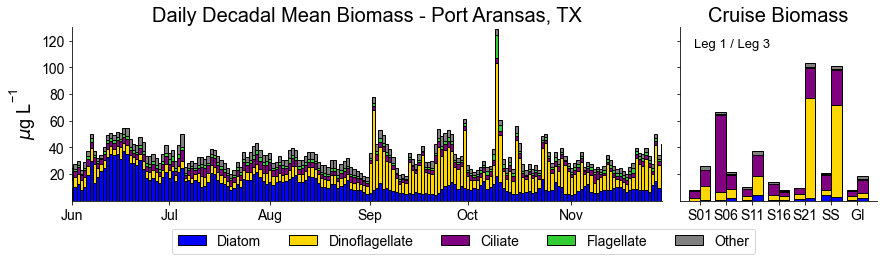

In [61]:
cats = [dia_cnn, dinos_cnn, cili_cnn, flags_cnn, unused_cnn]

test = 0
c = ['blue','gold','purple','limegreen','grey']
subset = fullyear.loc[151:333]

fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3,1]}, figsize = [12,3], sharey = True)

for i in range(0,len(cats)):
    ax[0].bar(subset.index, subset[cats[i]].sum(axis=1)/1000, width = 1, bottom = test, 
           align = 'center', color = c[i],edgecolor = 'k')
    test = test + subset[cats[i]].sum(axis=1)/1000
           
matplotlib.rc('ytick', labelsize=14) 

ax[0].set_xlim([151,333])
ax[0].set_xticks([151, 181, 212,243, 273,305])
ax[0].set_xticklabels(['Jun','Jul','Aug','Sep','Oct','Nov'], fontsize = 14)
ax[0].set_ylim([0,130])
plt.tight_layout()
ax[0].set_title('Daily Decadal Mean Biomass - Port Aransas, TX', fontsize = 20)
plt.yticks([20,40,60,80,100,120])
ax[0].set_yticklabels(['20','40','60','80','100','120'])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel(r'$\mu$g $\mathregular{L^{-1}}$', fontsize = 18)

l1 = l1.reindex(['S01','S06','S11','S16','S21','SS','GI'])
l3 = l3.reindex(['S01','S06','S11','S16','S21','SS','GI'])

test = 0
width = 0.4
ind = np.arange(0,len(l1.index))
for i in range(0,len(cats)):
    ax[1].bar(ind, l1[cats[i]].sum(axis=1)/1000, width, bottom = test, align = 'center', color = c[i], edgecolor = 'k')
    test = test + l1[cats[i]].sum(axis=1)/1000
    
test = 0
for i in range(0,len(cats)):
    ax[1].bar(ind+width, l3[cats[i]].sum(axis=1)/1000, width, bottom = test, align = 'center', color = c[i], 
              edgecolor = 'k')
    test = test + l3[cats[i]].sum(axis=1)/1000
    
ax[1].set_xticklabels(l1.index, fontsize = 14)
ax[1].set_xticks(ind+width/2)
ax[1].set_title('Cruise Biomass', fontsize = 20)
ax[1].text(0,115,'Leg 1 / Leg 3', fontsize = 13)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.legend(['Diatom','Dinoflagellate','Ciliate','Flagellate','Other'], ncol = 5, 
          bbox_to_anchor = (-1.1, -0.12), loc = 'upper center', fontsize = 14)

fig.savefig('path',dpi=600,bbox_inches = 'tight')

In [4]:
simple_counts

,Diatoms,Dinoflagellates,Ciliates,Flagellates,Other
0,6154.196280,3668.099835,3498.001808,1585.098951,3918.873248
1,2118.512916,1181.625341,222.128071,621.156270,1105.111801
2,2255.139845,4901.164897,2192.849793,306.915643,1852.687247
3,688.874280,3848.949659,8204.725104,248.991213,1193.998757


0    0.326929
1    0.403639
2    0.195950
3    0.048562
dtype: float64
0    0.521789
1    0.628773
2    0.621814
3    0.319891
dtype: float64
0    0.707613
1    0.671095
2    0.812351
3    0.898277
dtype: float64
0    0.791818
1    0.789444
2    0.839019
3    0.915830
dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
dtype: float64


Text(0.5, 0, 'Median %Biomass')

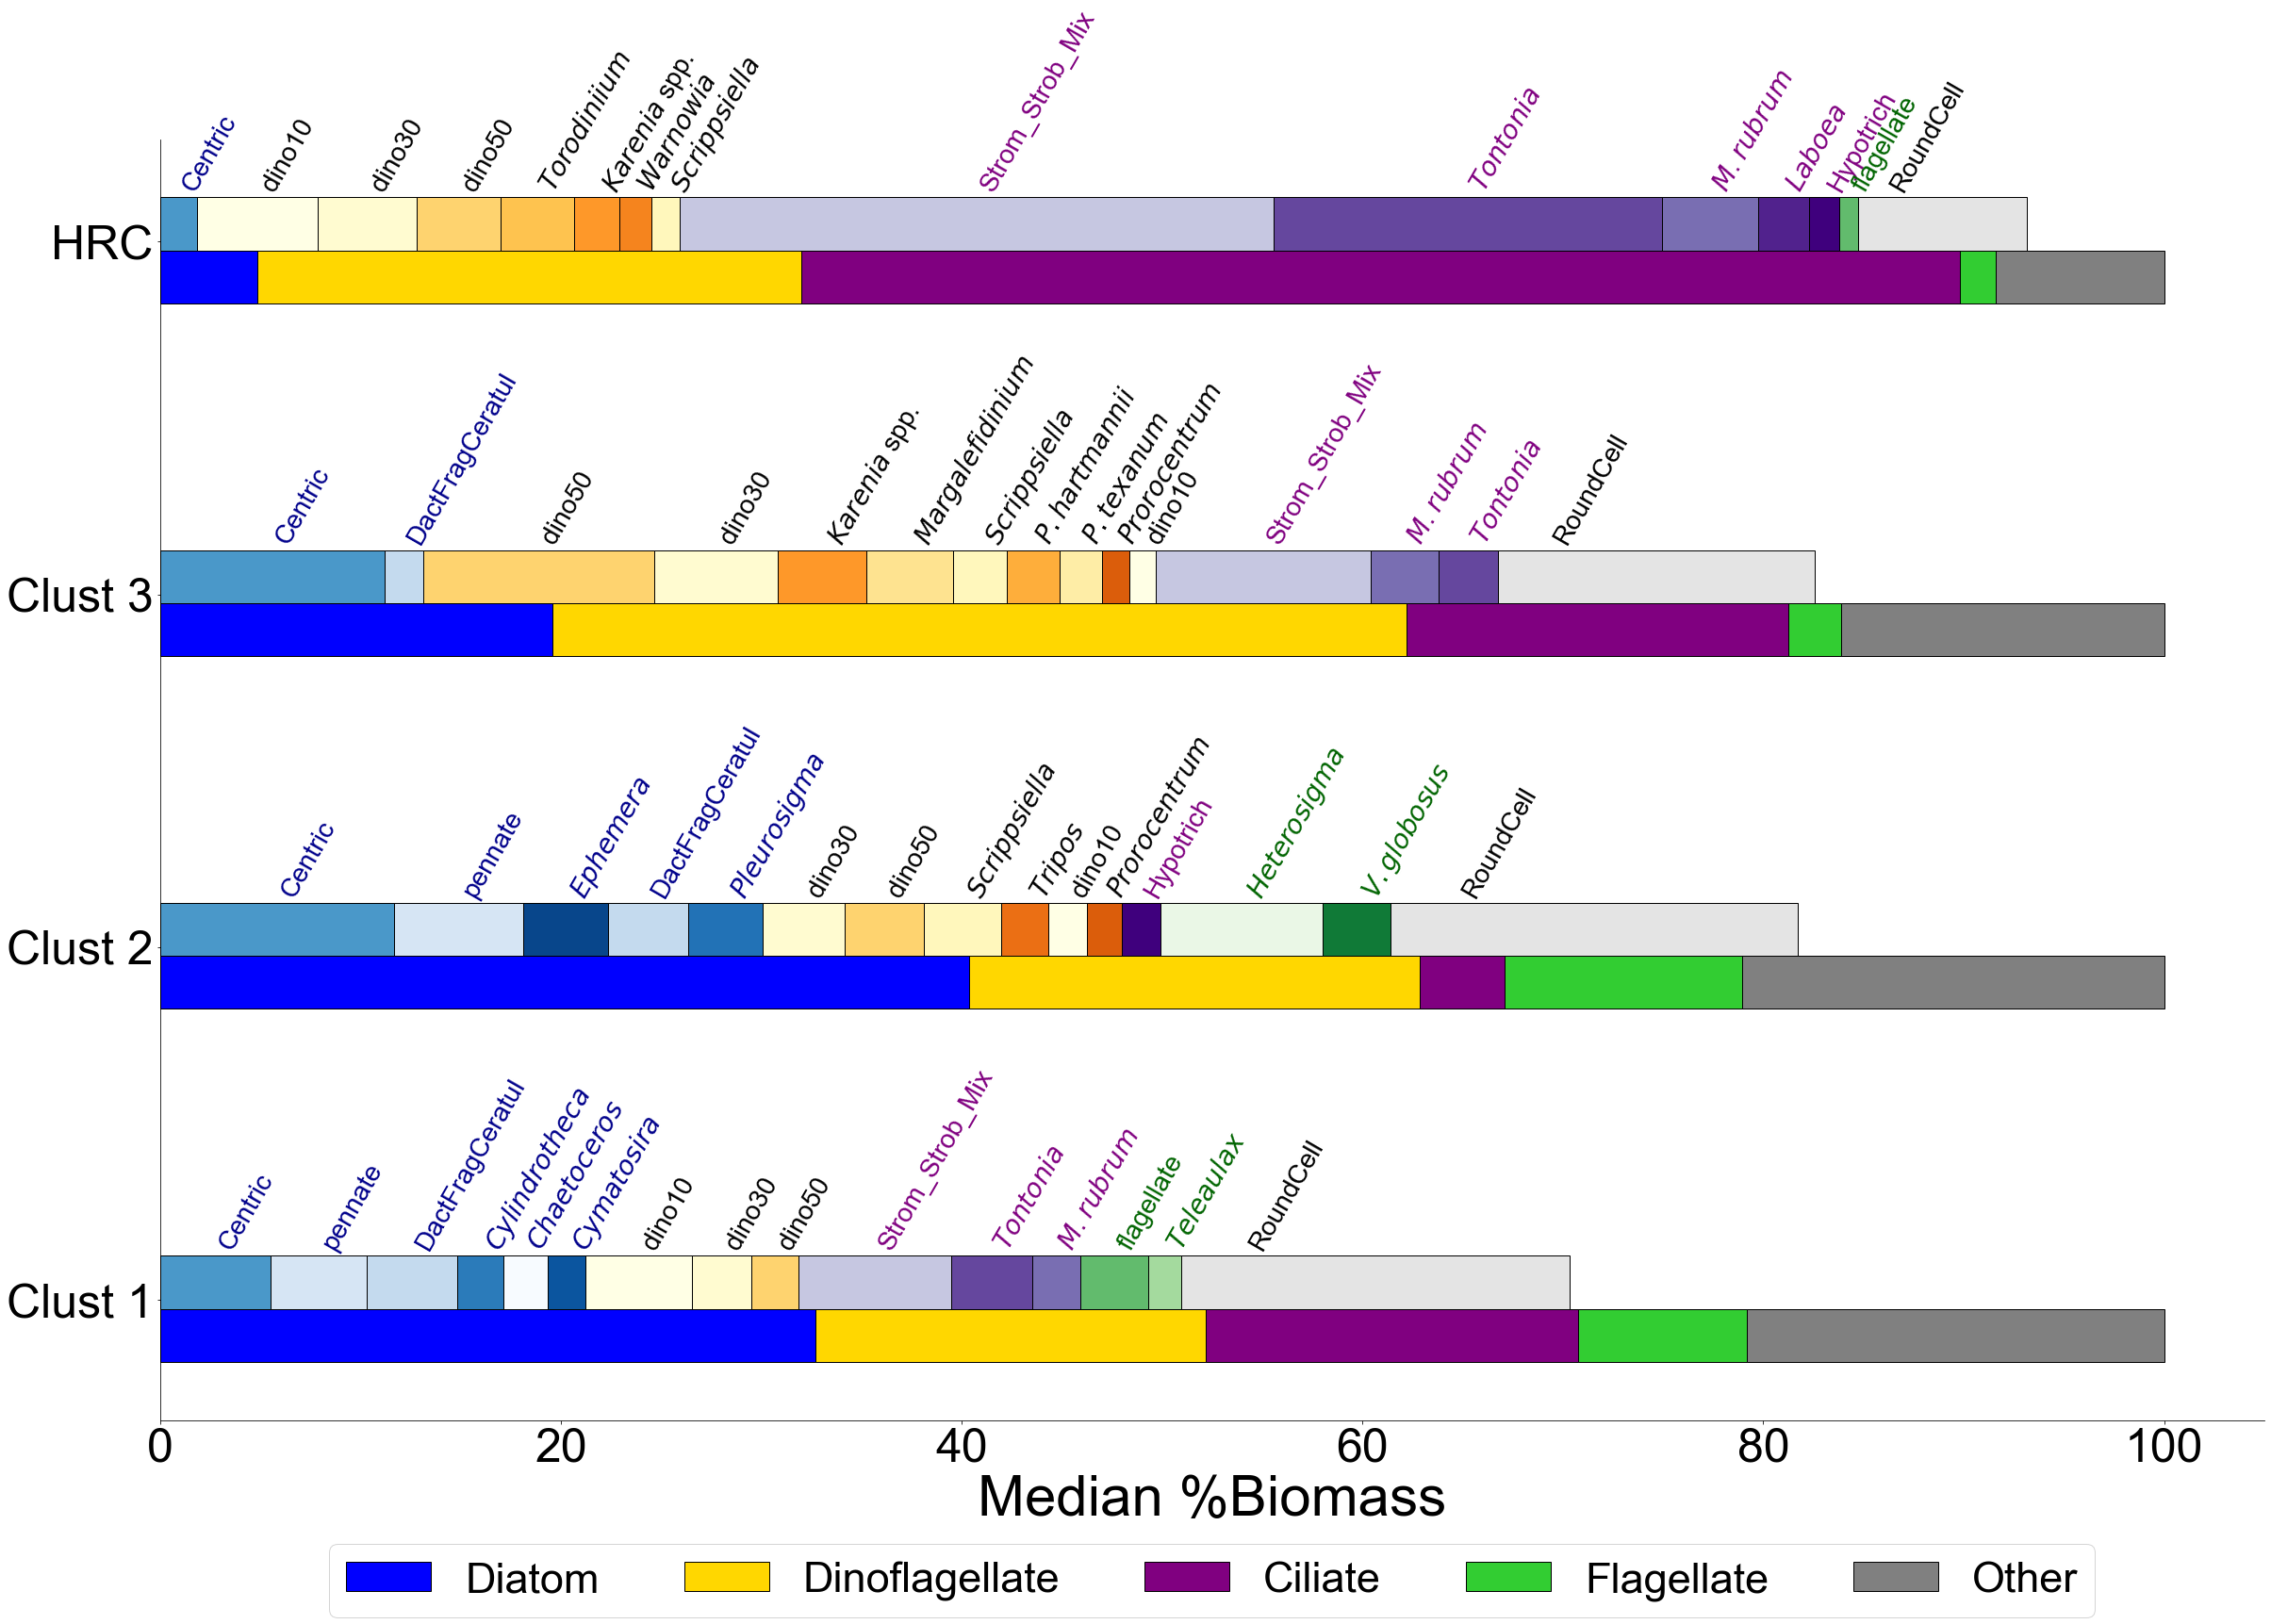

In [3]:
kmean = pd.read_csv('path',header = 0,index_col = 0)
time = kmean
kmean[kmean.columns[0:105]] = 10**kmean[kmean.columns[0:105]] - 1
hrr = kmean[kmean['station'] == 'cruise']
hrr = hrr[hrr.columns[0:105]]
hrr = pd.DataFrame(hrr.median()).T
m = kmean.groupby(kmean['clust']).median()
counts = m[m.columns[0:105]]
counts = counts.append(hrr)

counts = counts.reset_index(drop = True)

#Simplify into major groups
simplecol = ['Diatoms','Dinoflagellates','Ciliates','Flagellates']
simple_counts = pd.DataFrame(index = [0,1,2,3], columns = simplecol)

test = [dia_cnn, dinos_cnn, cili_cnn, flags_cnn]

simple_counts['Other'] = counts[unused_cnn].sum(axis=1)

for i in range(0,len(test)):
    simple_counts[simple_counts.columns[i]] = counts[test[i]].sum(axis=1)


fig, ax = plt.subplots(figsize = [40, 25])
test = 0

#Set colors
c = ['blue','gold','purple','limegreen','grey']

ind = np.arange(len(simple_counts.index))
width = 0.15

#Dictionary
it = {'Teleaulax':'$\it{Teleaulax}$','flagellate':'flagellate','Heterosigma':'$\it{Heterosigma}$','pennate':'pennate',
     'Chaetoceros':'$\it{Chaetoceros}$', 'DactFragCeratul':'DactFragCeratul', 'Cylindrotheca':'$\it{Cylindrotheca}$',
     'Thalassionema':'$\it{Thalassionema}$', 'Cymatosira':'$\it{Cymatosira}$', 'Asterionellopsis':'$\it{Asterionellopsis}$',
     'Leptocylindrus':'$\it{Leptocylindrus}$','Thalassiosira':'$\it{Thalassiosira}$',
     'Chaetoceros_single':'$\it{Chaetoceros}$ single', 'dino10':'dino10','dino30':'dino30','dino50':'dino50',
     'Centric':'Centric','centric10':'centric10','Scrippsiella':'$\it{Scrippsiella}$','Karenia_spp':'$\it{Karenia}$ spp.',
     'Margalefidinium':'$\it{Margalefidinium}$', 'Strom_Strob_Mix':'Strom_Strob_Mix',
     'Mesodinium_rubrum':'$\it{M}$. $\it{rubrum}$', 'Pleurosigma':'$\it{Pleurosigma}$', 
      'Torodinium':'$\it{Torodiniium}$', 'Tontonia':'$\it{Tontonia}$', 'Warnowia':'$\it{Warnowia}$',
      'Tripos':'$\it{Tripos}$','Laboea':'$\it{Laboea}$','Hypotrich':'Hypotrich','P_texanum':'$\it{P. texanum}$',
     'Prorocentrum':'$\it{Prorocentrum}$','P_hartmannii':'$\it{P. hartmannii}$',
      'Vicicitus_globosus':'$\it{V. globosus}$','Ephemera':'$\it{Ephemera}$'}

for i in range(0,len(simple_counts.iloc[1,:])):
    ax.barh(ind,(simple_counts.iloc[:,i]/simple_counts.sum(axis=1)), width, left = test, 
           align = 'center', color = c[i],edgecolor = 'k')
    test = test + simple_counts.iloc[:,i]/simple_counts.sum(axis=1)
    print(test)
    

ax.legend(['Diatom','Dinoflagellate','Ciliate','Flagellate','Other'], ncol = 5, 
          bbox_to_anchor = (0.5, -0.08), loc = 'upper center', fontsize = 45)

#Add dominant species
aux = counts.transpose()

#Diatom colors
evenly_spaced_interval = np.linspace(0, 1, len(dia_cnn))
colors = [cm.Blues(t) for t in evenly_spaced_interval]
diatom_cols = {}
for key in dia_cnn:
    for value in colors:
        diatom_cols[key] = value
        colors.remove(value)
        break

#Dino colors
dino_small = ['dino10','dino30','Scrippsiella','P_texanum','Margalefidinium','dino50','Torodinium','P_hartmannii',
              'Karenia_spp','Warnowia','Tripos','Prorocentrum']
dino_small = np.append(dino_small, dinos_cnn[0:5])
evenly_spaced_interval = np.linspace(0,1,len(dino_small))
colors = [cm.YlOrBr(t) for t in evenly_spaced_interval]
dino_cols = {}
for key in dino_small:
    for value in colors:
        dino_cols[key] = value
        colors.remove(value)
        break
        
evenly_spaced_interval = np.linspace(0,1,len(cili_cnn))
colors = [cm.Purples(t) for t in evenly_spaced_interval]
cili_cols = {}
for key in cili_cnn:
    for value in colors:
        cili_cols[key] = value
        colors.remove(value)
        break
    
evenly_spaced_interval = np.linspace(0,1,len(flags_cnn))
colors = [cm.Greens(t) for t in evenly_spaced_interval]
flag_cols = {}
for key in flags_cnn:
    for value in colors:
        flag_cols[key] = value
        colors.remove(value)
        break
        
evenly_spaced_interval = np.linspace(0,1,len(unused_cnn))
colors = [cm.Greys(t) for t in evenly_spaced_interval]
other_cols = {}
for key in unused_cnn:
    for value in colors:
        other_cols[key] = value
        colors.remove(value)
        break


for x in [3,0,1,2]:
    
    one = aux.nlargest(15,x, keep = 'all')
    one = one.transpose()

    test = 0
            
    for i in range(0,len(one.columns)):
        if one.columns[i] in dia_cnn:
            ax.barh(x+width,(one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test, 
               align = 'center', color = diatom_cols.get(one.columns[i]), edgecolor = 'k')
            test = test + one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/2, x+width*1.65, it.get(one.columns[i]), 
                    color = 'darkblue',fontsize = 28, rotation = 60)
        else:
            continue
            
    for i in range(0,len(one.columns)):  
        if one.columns[i] in dinos_cnn:
            ax.barh(x+width,(one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test, 
               align = 'center', color = dino_cols.get(one.columns[i]), edgecolor = 'k')
            test = test + one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/2, x+width*1.65, it.get(one.columns[i]),
                    color = 'k',fontsize = 28, rotation = 60)
        else:
            continue
    
    for i in range(0,len(one.columns)):
        if one.columns[i] in cili_cnn:
            ax.barh(x+width,(one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test, 
               align = 'center', color = cili_cols.get(one.columns[i]), edgecolor = 'k')
            test = test + one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/2, x+width*1.65, it.get(one.columns[i]),
                    color = 'Purple',fontsize = 28, rotation = 60)
            
        else:
            continue
            
    for i in range(0,len(one.columns)):
        if one.columns[i] in flags_cnn:
            ax.barh(x+width, (one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test,
                  align = 'center', color = flag_cols.get(one.columns[i]), edgecolor = 'k')
            test = test+one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/2, x+width*1.65, it.get(one.columns[i]),
                   color = 'darkgreen', fontsize = 28, rotation = 60)
        else:
            continue
            
    for i in range(0,len(one.columns)):
        if one.columns[i] in unused_cnn:
            ax.barh(x+width, (one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test,
                  align = 'center', color = other_cols.get(one.columns[i]), edgecolor = 'k')
            test = test+one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/1.2, x+width*1.65, one.columns[i],
                   color = 'k', fontsize = 28, rotation = 60)
        else:
            continue
            
ax.set_yticks([0.1, 1.1, 2.1, 3.1])
ax.set_yticklabels(['Clust 1','Clust 2','Clust 3','HRC'], fontsize = 50)
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels([0,20,40,60,80,100],fontsize = 50)
#ax.set_xlim([0,0.7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Median %Biomass', fontsize = 60)

Text(0.5, 0, '% Median Biomass')

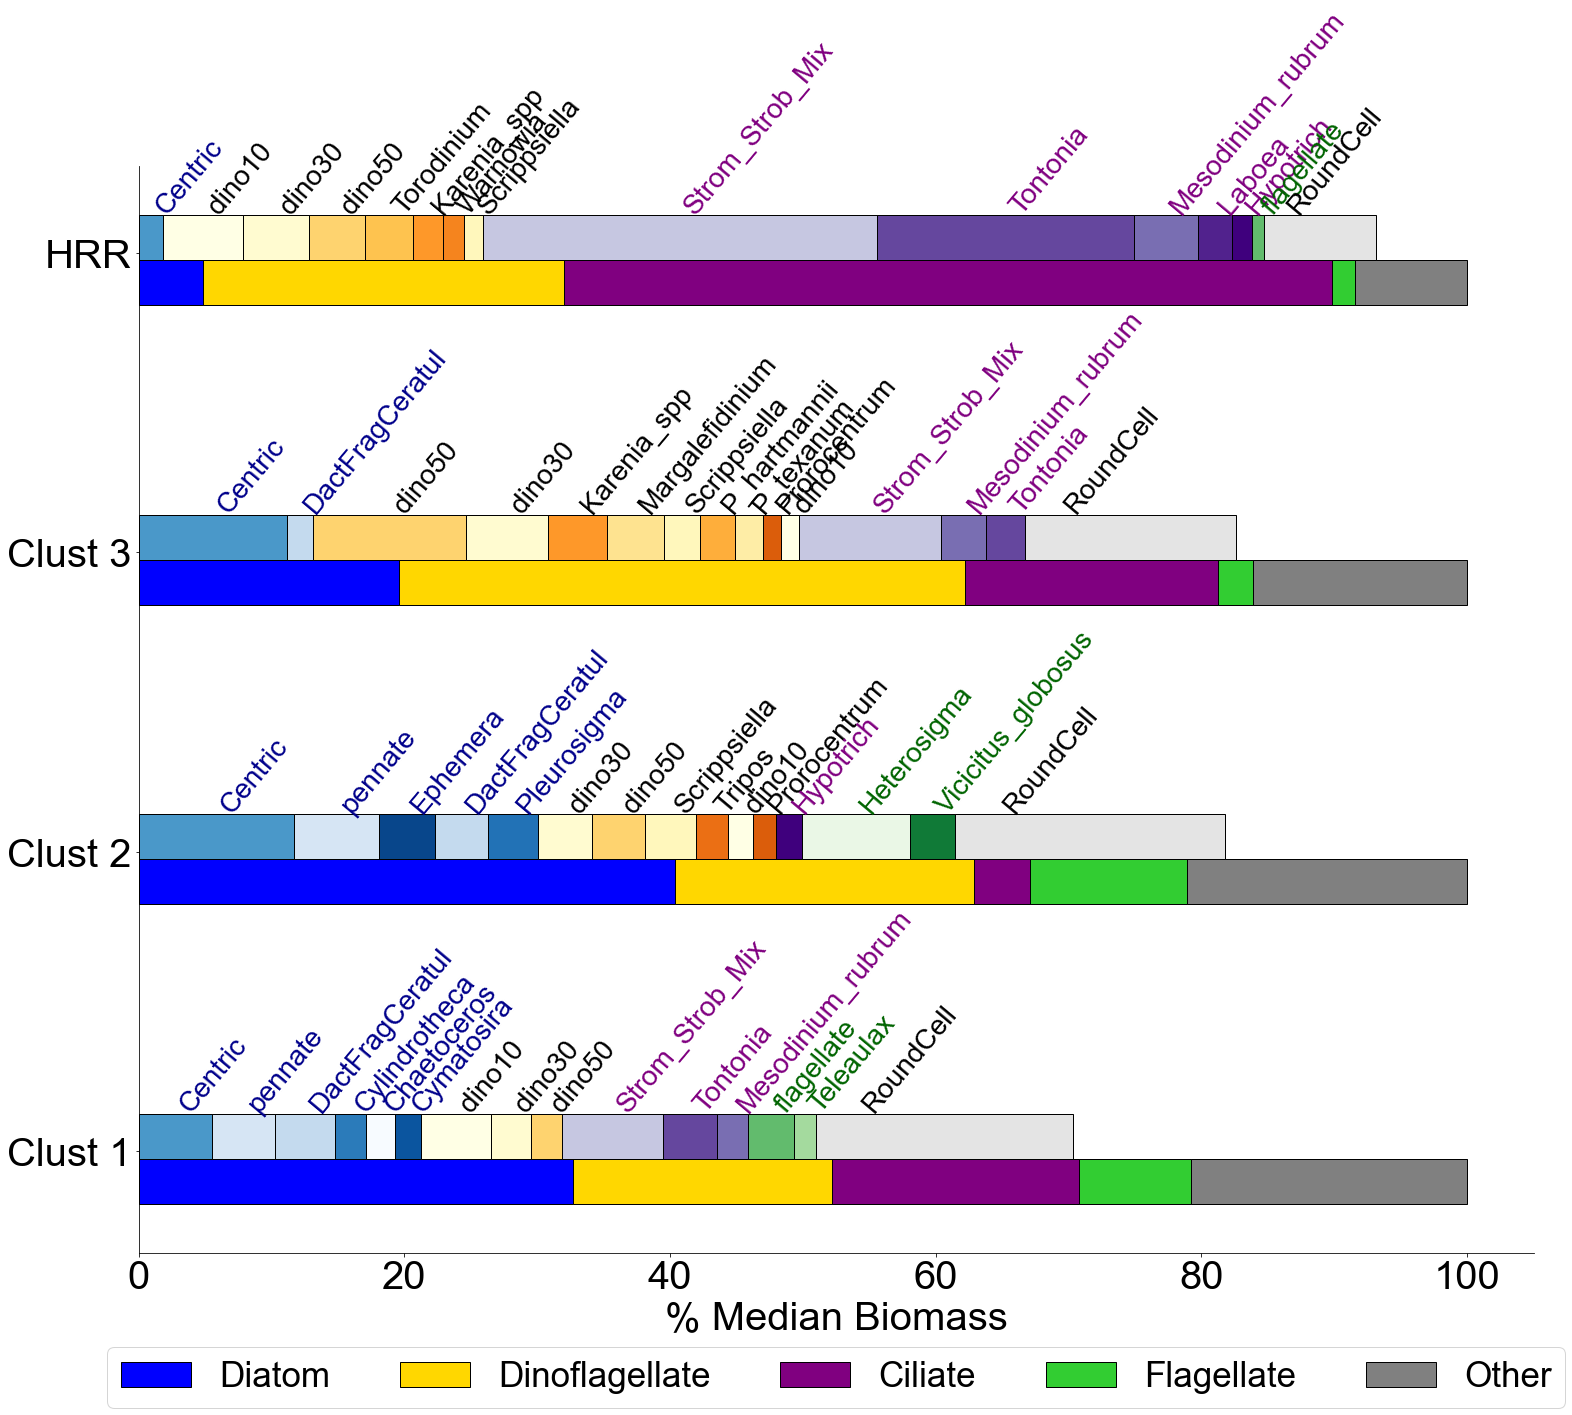

In [22]:
kmean = pd.read_csv('path',header = 0,index_col = 0)
time = kmean
kmean[kmean.columns[0:105]] = 10**kmean[kmean.columns[0:105]] - 1
hrr = kmean[kmean['station'] == 'cruise']
hrr = hrr[hrr.columns[0:105]]
hrr = pd.DataFrame(hrr.median()).T
m = kmean.groupby(kmean['clust']).median()
counts = m[m.columns[0:105]]
counts = counts.append(hrr)

counts = counts.reset_index(drop = True)

#Simplify into major groups
simplecol = ['Diatoms','Dinoflagellates','Ciliates','Flagellates']
simple_counts = pd.DataFrame(index = [0,1,2,3], columns = simplecol)

test = [dia_cnn, dinos_cnn, cili_cnn, flags_cnn]

simple_counts['Other'] = counts[unused_cnn].sum(axis=1)

for i in range(0,len(test)):
    simple_counts[simple_counts.columns[i]] = counts[test[i]].sum(axis=1)


fig, ax = plt.subplots(figsize = [25, 20])
test = 0

#Set colors
c = ['blue','gold','purple','limegreen','grey']

ind = np.arange(len(simple_counts.index))
width = 0.15

#Dictionary
it = {'Teleaulax':'$\it{Teleaulax}$','flagellate':'flagellate','Heterosigma':'$\it{Heterosigma}$','pennate':'pennate',
     'Chaetoceros':'$\it{Chaetoceros}$', 'DactFragCeratul':'DactFragCeratul', 'Cylindrotheca':'$\it{Cylindrotheca}$',
     'Thalassionema':'$\it{Thalassionema}$', 'Cymatosira':'$\it{Cymatosira}$', 'Asterionellopsis':'$\it{Asterionellopsis}$',
     'Leptocylindrus':'$\it{Leptocylindrus}$','Thalassiosira':'$\it{Thalassiosira}$',
     'Chaetoceros_single':'$\it{Chaetoceros}$ single', 'dino10':'dino10','dino30':'dino30','dino50':'dino50',
     'Centric':'Centric','centric10':'centric10','Scrippsiella':'$\it{Scrippsiella}$','Karenia_spp':'$\it{Karenia}$ spp.',
     'Margalefidinium':'$\it{Margalefidinium}$', 'Strom_Strob_Mix':'Strom_Strob_Mix',
     'Mesodinium_rubrum':'$\it{M}$. $\it{rubrum}$', 'Pleurosigma':'$\it{Pleurosigma}$', 
      'Torodinium':'$\it{Torodiniium}$', 'Tontonia':'$\it{Tontonia}$', 'Warnowia':'$\it{Warnowia}$',
      'Tripos':'$\it{Tripos}$','Laboea':'$\it{Laboea}$','Hypotrich':'Hypotrich','P_texanum':'$\it{P. texanum}$',
     'Prorocentrum':'$\it{Prorocentrum}$','P_hartmannii':'$\it{P. hartmannii}$',
      'Vicicitus_globosus':'$\it{V. globosus}$'}

for i in range(0,len(simple_counts.iloc[1,:])):
    ax.barh(ind,(simple_counts.iloc[:,i]/simple_counts.sum(axis=1)), width, left = test, 
           align = 'center', color = c[i],edgecolor = 'k')
    test = test + simple_counts.iloc[:,i]/simple_counts.sum(axis=1)
    

ax.legend(['Diatom','Dinoflagellate','Ciliate','Flagellate','Other'], ncol = 5, 
          bbox_to_anchor = (0.5, -0.07), loc = 'upper center', fontsize = 35)

#Add dominant species
aux = counts.transpose()

#Diatom colors
evenly_spaced_interval = np.linspace(0, 1, len(dia_cnn))
colors = [cm.Blues(t) for t in evenly_spaced_interval]
diatom_cols = {}
for key in dia_cnn:
    for value in colors:
        diatom_cols[key] = value
        colors.remove(value)
        break

#Dino colors
dino_small = ['dino10','dino30','Scrippsiella','P_texanum','Margalefidinium','dino50','Torodinium','P_hartmannii',
              'Karenia_spp','Warnowia','Tripos','Prorocentrum']
dino_small = np.append(dino_small, dinos_cnn[0:5])
evenly_spaced_interval = np.linspace(0,1,len(dino_small))
colors = [cm.YlOrBr(t) for t in evenly_spaced_interval]
dino_cols = {}
for key in dino_small:
    for value in colors:
        dino_cols[key] = value
        colors.remove(value)
        break
        
evenly_spaced_interval = np.linspace(0,1,len(cili_cnn))
colors = [cm.Purples(t) for t in evenly_spaced_interval]
cili_cols = {}
for key in cili_cnn:
    for value in colors:
        cili_cols[key] = value
        colors.remove(value)
        break
    
evenly_spaced_interval = np.linspace(0,1,len(flags_cnn))
colors = [cm.Greens(t) for t in evenly_spaced_interval]
flag_cols = {}
for key in flags_cnn:
    for value in colors:
        flag_cols[key] = value
        colors.remove(value)
        break
        
evenly_spaced_interval = np.linspace(0,1,len(unused_cnn))
colors = [cm.Greys(t) for t in evenly_spaced_interval]
other_cols = {}
for key in unused_cnn:
    for value in colors:
        other_cols[key] = value
        colors.remove(value)
        break


for x in [3,0,1,2]:
    
    one = aux.nlargest(15,x, keep = 'all')
    one = one.transpose()

    test = 0
            
    for i in range(0,len(one.columns)):
        if one.columns[i] in dia_cnn:
            ax.barh(x+width,(one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test, 
               align = 'center', color = diatom_cols.get(one.columns[i]), edgecolor = 'k')
            test = test + one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/2, x+width*1.55, one.columns[i], 
                    color = 'darkblue',fontsize = 28, rotation = 50)
        else:
            continue
            
    for i in range(0,len(one.columns)):  
        if one.columns[i] in dinos_cnn:
            ax.barh(x+width,(one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test, 
               align = 'center', color = dino_cols.get(one.columns[i]), edgecolor = 'k')
            test = test + one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/2, x+width*1.55, one.columns[i],
                    color = 'k',fontsize = 28, rotation = 50)
        else:
            continue
    
    for i in range(0,len(one.columns)):
        if one.columns[i] in cili_cnn:
            ax.barh(x+width,(one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test, 
               align = 'center', color = cili_cols.get(one.columns[i]), edgecolor = 'k')
            test = test + one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/2, x+width*1.55, one.columns[i],
                    color = 'Purple',fontsize = 28, rotation = 50)
            
        else:
            continue
            
    for i in range(0,len(one.columns)):
        if one.columns[i] in flags_cnn:
            ax.barh(x+width, (one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test,
                  align = 'center', color = flag_cols.get(one.columns[i]), edgecolor = 'k')
            test = test+one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/2, x+width*1.55, one.columns[i],
                   color = 'darkgreen', fontsize = 28, rotation = 50)
        else:
            continue
            
    for i in range(0,len(one.columns)):
        if one.columns[i] in unused_cnn:
            ax.barh(x+width, (one.iloc[x,i]/simple_counts.iloc[x,:].sum()), width, left = test,
                  align = 'center', color = other_cols.get(one.columns[i]), edgecolor = 'k')
            test = test+one.iloc[x,i]/simple_counts.iloc[x,:].sum()
            ax.text(test - (one.iloc[x,i]/simple_counts.iloc[x,:].sum())/1.2, x+width*1.55, one.columns[i],
                   color = 'k', fontsize = 28, rotation = 50)
        else:
            continue
            
ax.set_yticks([0.1, 1.1, 2.1, 3.1])
ax.set_yticklabels(['Clust 1','Clust 2','Clust 3','HRR'], fontsize = 40)
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels([0,20,40,60,80,100],fontsize = 40)
#ax.set_xlim([0,0.7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('% Median Biomass', fontsize = 40)